In [140]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import butter, lfilter

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BrainFlowError, BoardIds


# Import the custom module.
from brainflow_stream import BrainFlowBoardSetup

In [141]:
board_id = BoardIds.CYTON_BOARD.value # Set the board_id to match the Cyton board

# Lets quickly take a look at the specifications of the Cyton board
for item1, item2 in BoardShim.get_board_descr(board_id).items():
    print(f"{item1}: {item2}")

accel_channels: [9, 10, 11]
analog_channels: [19, 20, 21]
ecg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eeg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eeg_names: Fp1,Fp2,C3,C4,P7,P8,O1,O2
emg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eog_channels: [1, 2, 3, 4, 5, 6, 7, 8]
marker_channel: 23
name: Cyton
num_rows: 24
other_channels: [12, 13, 14, 15, 16, 17, 18]
package_num_channel: 0
sampling_rate: 250
timestamp_channel: 22


In [142]:
cyton_board = BrainFlowBoardSetup(
                                board_id = board_id,
                                name = 'Board_1', # Optional name for the board. This is useful if you have multiple boards connected and want to distinguish between them.
                                serial_port = None # If the serial port is not specified, it will try to auto-detect the board. If this fails, you will have to assign the correct serial port. See https://docs.openbci.com/GettingStarted/Boards/CytonGS/ 
                                ) 

cyton_board.setup() # This will establish a connection to the board and start streaming data.

[Board_1, COM3] Streaming stopped.
[Board_1, COM3] Session released.
No serial port provided, attempting to auto-detect...
Compatible device found: Serial Number: DM01IK21A, Description: USB Serial Port (COM3)
[Board_1, COM3] Board setup and streaming started successfully.


In [143]:
# board_info = cyton_board.get_board_info() # Retrieves the EEG channel and sampling rate of the board.
# print(f"Board info: {board_info}")

# board_srate = cyton_board.get_sampling_rate() # Retrieves the sampling rate of the board.
# print(f"Board sampling rate: {board_srate}")

In [144]:
# Function to create a bandpass filter for beta waves (13-30 Hz)

def bandpass_filter(data, lowcut=13, highcut=30, fs=SAMPLE_RATE, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)

    return y

In [145]:
def remove_dc_offset(data):
    return data[1:9, :] - np.mean(data[1:9, :], axis=1, keepdims=True)

In [146]:
# Function to convert EEG data to an MNE object
def convert_to_mne(data, sfreq):
    ch_names = [f'EEG {i+1}' for i in range(data.shape[0])]
    ch_types = ['eeg'] * data.shape[0]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    return mne.io.RawArray(data, info)

In [147]:
# Function to compute power spectral density and extract beta waves
def extract_beta_power(raw):
    psd, freqs = mne.time_frequency.psd_array_welch(raw.get_data(), sfreq=raw.info['sfreq'], fmin=13, fmax=30, n_fft=512)
    psd = np.maximum(psd, np.finfo(float).eps)
    psd_db = 10 * np.log10(psd)  # Convert power to dB
    return mne.io.RawArray(psd_db, raw.info)

Creating RawArray with float64 data, n_channels=8, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.
Effective window size : 2.048 (s)
Creating RawArray with float64 data, n_channels=8, n_times=35
    Range : 0 ... 34 =      0.000 ...     0.136 secs
Ready.
(8, 750)
(8, 35)


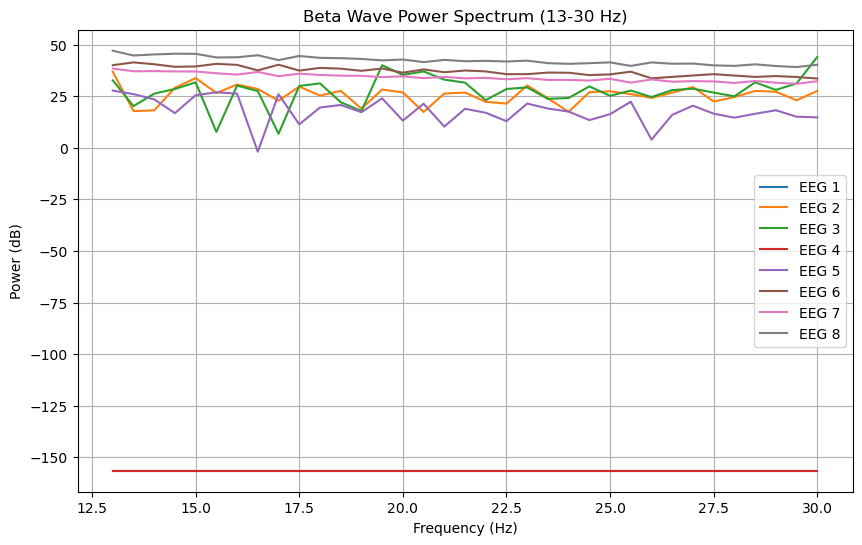

Creating RawArray with float64 data, n_channels=8, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.
Effective window size : 2.048 (s)
Creating RawArray with float64 data, n_channels=8, n_times=35
    Range : 0 ... 34 =      0.000 ...     0.136 secs
Ready.
(8, 750)
(8, 35)


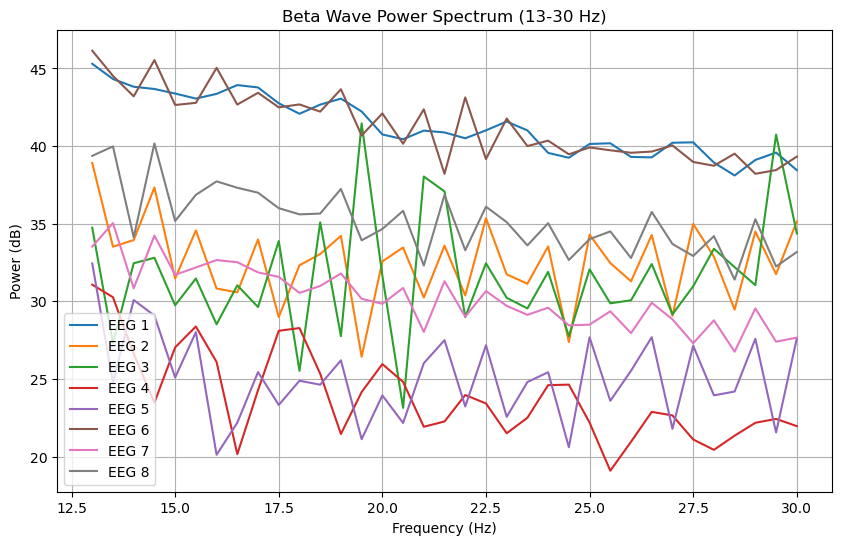

Creating RawArray with float64 data, n_channels=8, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.
Effective window size : 2.048 (s)
Creating RawArray with float64 data, n_channels=8, n_times=35
    Range : 0 ... 34 =      0.000 ...     0.136 secs
Ready.
(8, 750)
(8, 35)


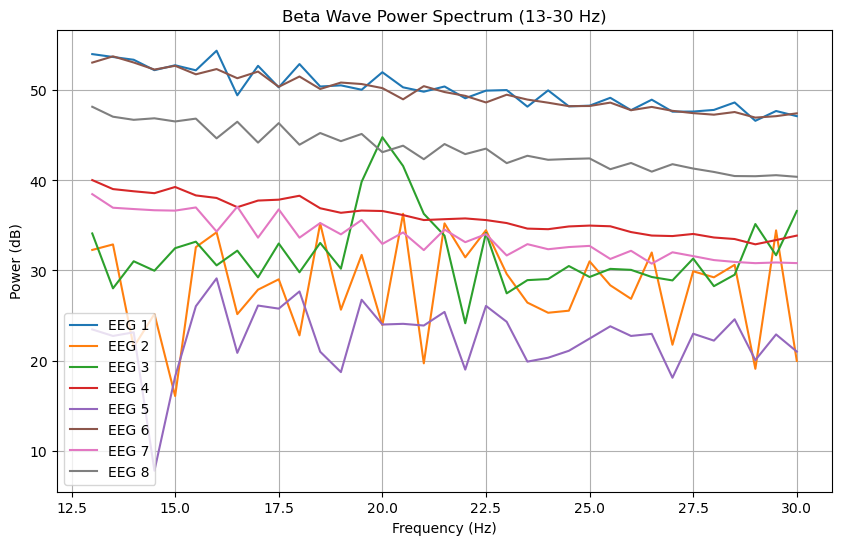

In [150]:
period_sum = []
sampling_rate = 1
total_time = 30
total_periods = total_time / sampling_rate + 1
num_samples = sampling_rate * 250

for i in range(3):
    time.sleep(1)

    period_data = cyton_board.get_current_board_data(num_samples = 250 * 3)
    data_eeg = period_data[1:9, :]
    data_eeg = remove_dc_offset(period_data) # Remove DC offset

    data_mne = convert_to_mne(data_eeg, 250)
    beta_power = extract_beta_power(data_mne)

    print(data_eeg.shape)
    print(beta_power.get_data().shape)  # Correct way to check shape

    freqs = np.linspace(13, 30, beta_power.get_data().shape[1])  # Generate frequency bins
    power_values = beta_power.get_data()  # Get power values

    period_sum.append(np.sum(power_values))

    # Plot power spectrum for each EEG channel
    plt.figure(figsize=(10, 6))
    for i in range(power_values.shape[0]):  # Loop through channels
        plt.plot(freqs, power_values[i], label=f'EEG {i+1}')

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title("Beta Wave Power Spectrum (13-30 Hz)")
    plt.legend()
    plt.grid(True)
    plt.show()   




In [149]:
period_sum

[np.float64(9496.724811776077),
 np.float64(8631.474568872869),
 np.float64(7559.67451955913)]